In [1]:
# This code works in Python 3.10.6
import os
import os.path as osp
from typing import Dict, List, Union

import torch
import torch.nn.functional as F
from torch import nn
import dgl
import torch_geometric.transforms as T
from torch_geometric.datasets import IMDB
from torch_geometric.nn import HANConv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
import random
import seaborn as sns
import torch_geometric.utils.convert
from torch import optim
from torch_geometric.data import HeteroData

from torch_geometric.nn import HeteroConv, Linear, SAGEConv

import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


In [3]:
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

Original IMDB dataset with all node features

In [4]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


In [5]:
movie_data = data['movie'].x
df_movie = pd.DataFrame(movie_data)
            
X = df_movie
col_sum = X.sum(axis=0)
colsum_df = pd.DataFrame(col_sum)

sorted_colsum = sorted(col_sum, reverse=True)[:10]
index_list = list(np.ravel(colsum_df[colsum_df[0].isin(sorted_colsum)].index))

imp_feat_movie = X[index_list]
imp_feat_movie.head()

,1023,1111,1381,1624,1654,1900,1914,1928,2393,2774
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
director_df = pd.DataFrame(data['director'].x.numpy())
corr = director_df.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.3).any()
real = corr.loc[m]
list_index = np.ravel(real.index).tolist()
imp_feat_director = director_df[list_index]
imp_feat_director.head()

,3,177,240,249,255,295,316,368,371,392,...,2665,2699,2717,2718,2736,2781,2856,2905,2946,3045
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
actor_df = pd.DataFrame(data['actor'].x.numpy())
corr = actor_df.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.2).any()
real = corr.loc[m]
list_index = np.ravel(real.index).tolist()
imp_feat_actor = actor_df[list_index]
imp_feat_actor.head()

,76,89,92,192,280,435,652,1036,1055,1380,...,2042,2265,2278,2507,2544,2665,2893,2983,2985,3052
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data['movie'].x = torch.tensor(imp_feat_movie.values).to(dtype=torch.float32)
data['director'].x = torch.tensor(imp_feat_director.values).to(dtype=torch.float32)
data['actor'].x = torch.tensor(imp_feat_actor.values).to(dtype=torch.float32)

Dataset with selected node features used for GNN training

In [9]:
data

HeteroData(
  movie={
    x=[4278, 10],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 79] },
  actor={ x=[5257, 25] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

In [10]:
class HAN(nn.Module):
    def __init__(self, in_channels: Union[int, Dict[str, int]],
                 out_channels: int, hidden_channels=128, heads=8):
        super().__init__()
        self.han_conv = HANConv(in_channels, hidden_channels, heads=heads,
                                dropout=0.6, metadata=data.metadata())
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        out = self.han_conv(x_dict, edge_index_dict)
        out = self.lin(out['movie'])
        return out


model = HAN(in_channels=-1, out_channels=3)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train() -> float:
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['movie'].train_mask
    loss = F.cross_entropy(out[mask], data['movie'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test() -> List[float]:
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['movie'][split]
        acc = (pred[mask] == data['movie'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


best_val_acc = 0
start_patience = patience = 200
for epoch in range(1, 700):

    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

    if best_val_acc <= val_acc:
        patience = start_patience
        best_val_acc = val_acc
    else:
        patience -= 1

    if patience <= 0:
        print('Stopping training as validation accuracy did not improve '
              f'for {start_patience} epochs')
        break

Epoch: 010, Loss: 1.0631, Train: 0.4400, Val: 0.4075, Test: 0.3692
Epoch: 020, Loss: 1.0239, Train: 0.5175, Val: 0.4375, Test: 0.3884
Epoch: 030, Loss: 0.9814, Train: 0.5550, Val: 0.4650, Test: 0.4152
Epoch: 040, Loss: 0.9391, Train: 0.5825, Val: 0.4650, Test: 0.4273
Epoch: 050, Loss: 0.9011, Train: 0.6175, Val: 0.4700, Test: 0.4370
Epoch: 060, Loss: 0.8690, Train: 0.6275, Val: 0.4750, Test: 0.4390
Epoch: 070, Loss: 0.8848, Train: 0.6400, Val: 0.4725, Test: 0.4431
Epoch: 080, Loss: 0.8565, Train: 0.6425, Val: 0.4600, Test: 0.4382
Epoch: 090, Loss: 0.8364, Train: 0.6450, Val: 0.4625, Test: 0.4362
Epoch: 100, Loss: 0.8426, Train: 0.6475, Val: 0.4600, Test: 0.4382
Epoch: 110, Loss: 0.8320, Train: 0.6550, Val: 0.4525, Test: 0.4310
Epoch: 120, Loss: 0.8009, Train: 0.6550, Val: 0.4625, Test: 0.4301
Epoch: 130, Loss: 0.8301, Train: 0.6500, Val: 0.4550, Test: 0.4347
Epoch: 140, Loss: 0.7986, Train: 0.6575, Val: 0.4750, Test: 0.4330
Epoch: 150, Loss: 0.7988, Train: 0.6525, Val: 0.4675, Test: 0.

In [11]:
import random
def apply_threshold(df):
    return df.applymap(lambda x: random.uniform(-1.0, 0.0) if x == 0.0 else random.uniform(0.1, 1.0))

In [12]:
#Reading from files, the generated node features using diffusion
class_path = '../sampled_features/imdb/'
class0  = pd.DataFrame(torch.load(class_path + 'features10_0.pt')[0].cpu().numpy())
class1  = pd.DataFrame(torch.load(class_path + 'features10_1.pt')[0].cpu().numpy())
class2  = pd.DataFrame(torch.load(class_path + 'features10_2.pt')[0].cpu().numpy())

director  = pd.DataFrame(torch.load(class_path + 'features79_director.pt')[0].cpu().numpy())
actor  = pd.DataFrame(torch.load(class_path + 'features25_actor.pt')[0].cpu().numpy())

director = apply_threshold(pd.DataFrame(director))
actor = apply_threshold(pd.DataFrame(actor))

df_class0=class0.reset_index(drop=True)
df_class1=class1.reset_index(drop=True)
df_class2=class2.reset_index(drop=True)



def get_node_features(G):
    nodes = []
    director_node_features = []
    movie_node_features = []
    movie_class = []
    actor_node_features = []

    for key, value in G.nodes(data=True):

        nodes.append(key)
        edges = [e for e in G.edges]
        node_id = G.nodes[key]["label"]
        node_type = G.nodes[key]["color_val"]
        if node_type == 0:

            node_id = G.nodes[key]["label"]

            director_node = director.loc[int(node_id), :].values.flatten().tolist()
            director_node_features.append(director_node)
        elif node_type == 2:

            node_class = random.choice([0, 1, 2])

            if node_class == 0:
                
                movie_node = df_class0.loc[int(node_id), :].values.flatten().tolist()
                movie_class.append(0)
                movie_node_features.append(movie_node)
                
            elif node_class == 1:
                
                movie_node = df_class1.loc[int(node_id), :].values.flatten().tolist()
                movie_class.append(1)
                movie_node_features.append(movie_node)
                
            elif node_class == 2:
                
                movie_node = df_class2.loc[int(node_id), :].values.flatten().tolist()
                movie_class.append(2)
                movie_node_features.append(movie_node)

        elif node_type == 1:
   
            actor_node = actor.loc[int(node_id), :].values.flatten().tolist()
            actor_node_features.append(actor_node)


        movie_node_features_df = pd.DataFrame(movie_node_features)
        movie_node_features_df['class'] = movie_class
        director_node_features_df = pd.DataFrame(director_node_features)
        actor_node_features_df = pd.DataFrame(actor_node_features)

    return nodes, edges, movie_node_features_df, director_node_features_df, actor_node_features_df


In [13]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [14]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [15]:
def get_node_type(node_type):
    if node_type == 1:
        return 'actor'
    elif node_type == 0:
        return 'director'
    elif node_type == 2:
        return 'movie'


In [16]:
all_edges = {}

In [17]:
#List of edges in metagraph of DBLP
list(meta_g.edges())

[('actor', 'movie'),
 ('movie', 'actor'),
 ('movie', 'director'),
 ('director', 'movie')]

In [18]:
def create_dataset(nodes,edges,movie_df,director_df,actor_df,node_id,df_graph):
    movie = np.asarray(movie_df.drop(columns=['class']))
    director = np.asarray(director_df)
    actor = np.asarray(actor_df)
    
    x_movie = torch.tensor(movie).to(dtype=torch.float32)
    y_movie = torch.tensor(np.array(movie_df["class"]), dtype=torch.long)
    x_director = torch.tensor(director).to(dtype=torch.float32)
    x_actor = torch.tensor(actor).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    movie_to_director = []
    director_to_movie = []
    movie_to_actor = []
    actor_to_movie = []
    remaining_edges = []

    class_dict = {'Director':0, 'Actor':1, 'Movie':2}

    for i in range(len(edges)):
        if (df_graph.iloc[int(source[i])]['class'] == class_dict['Movie']) and \
        (df_graph.iloc[int(dest[i])]['class'] == class_dict['Director']):
                movie_to_director.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Movie']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Actor']):
                movie_to_actor.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Director']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Movie']):
                director_to_movie.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Actor']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Movie']):
                actor_to_movie.append((int(source[i]),int(dest[i])))

        else:
            #The edges not present in the metagraph  
            source_node_type = get_node_type(df_graph.iloc[int(source[i])]['class'])
            dest_node_type = get_node_type(df_graph.iloc[int(dest[i])]['class'])
            remaining_edges.append((source_node_type,dest_node_type))
            #remaining_edges.append((int(source[i]),int(dest[i])))
            
    all_edges[node_id] = [*movie_to_director,*movie_to_actor,*director_to_movie,*actor_to_movie]
            
    actor = list(df_graph[df_graph['class'] == 1]['nodeId'])
    actor = [int(i) for i in actor]
    actor_nodes_mapping = remap_indices(actor)
    
    director = list(df_graph[df_graph['class'] == 0]['nodeId'])
    director = [int(i) for i in director]
    director_nodes_mapping = remap_indices(director)
    
    movie = list(df_graph[df_graph['class'] == 2]['nodeId'])
    movie = [int(i) for i in movie]
    movie_nodes_mapping = remap_indices(movie)

    node_list = {}
    for d in [movie_nodes_mapping, director_nodes_mapping, actor_nodes_mapping]:
        node_list.update(d)            

    #Create Hetero Data      
    small_graph = HeteroData({'movie':{'x': x_movie, 'y':y_movie}, 
                              'director':{'x': x_director},'actor':{'x': x_actor}})

    if movie_to_director:
        edge_index_movie_director = preprocess_edges(movie_to_director,node_list)
        small_graph['movie','to','director'].edge_index = edge_index_movie_director
        
    if director_to_movie:
        edge_index_director_movie = preprocess_edges(director_to_movie,node_list)
        small_graph['director','to','movie'].edge_index = edge_index_director_movie
    
    if actor_to_movie:
        edge_index_actor_movie = preprocess_edges(actor_to_movie,node_list)
        small_graph['actor','to','movie'].edge_index = edge_index_actor_movie
        
    if movie_to_actor:
        edge_index_movie_actor = preprocess_edges(movie_to_actor,node_list)
        small_graph['movie','to','actor'].edge_index = edge_index_movie_actor
    
    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)

    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph, remaining_edges

In [19]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['movie'].test_mask
        correct = (pred[mask] == small_graph['movie'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['movie'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [20]:
# import os 

# path = '../sampled_graphs/imdb' 

# files = os.listdir(path) 
# counter = 0
# for index, file in enumerate(files):
    
#     if file.endswith('.png'):
#         counter+=1
#         #print(file,counter)
#         os.rename(os.path.join(path, file), os.path.join(path, ''.join([str(counter), '.png'])))

In [21]:
import glob
print('Original no of graphs:',len([name for name in glob.iglob('../sampled_graphs/imdb/*.gexf')]))

Original no of graphs: 591


In [22]:
softmax_dict = {}
nodefeature_dict = {}
graph_dict = {}
original_edge_count = []
removed_edge_count = []
removed_edges_list = []

#Read from file the synthetic graphs generated using diffusion to evaluate the trained GNN on the graphs
for filepath in glob.iglob('../sampled_graphs/imdb/*.gexf'):
    #print(filepath)
    
    graph = nx.read_gexf(filepath)
    
    filename = os.path.basename(filepath)
    graph_id= filename.split('.')[0]
    
    nodeId_list = []
    node_type_list = []


    for key, value in graph.nodes(data=True):
        nodeId_list.append(key)
        node_type_list.append(value['color_val'])

    
    df_graph = pd.DataFrame()
    df_graph["nodeId"] = nodeId_list
    df_graph["class"] = node_type_list
  

    nodes,edges,movie_node_features,director_node_features,actor_node_features= get_node_features(graph)
    small_graph_data, removed_edges = create_dataset(nodes,edges,
                              movie_node_features,director_node_features,
                              actor_node_features,graph_id,df_graph)
    
    edge_list = all_edges[graph_id]
    graph = nx.Graph(edge_list)
    if not nx.is_empty(graph) and nx.is_connected(graph):
    
        if (small_graph_data['movie'].x.nelement()!=0) and \
                (small_graph_data['actor','to','movie']) :
            print(filepath)
            print('node count',small_graph_data.num_nodes)
            print('edge count',small_graph_data.num_edges)
            
            original_edge_count.append(len(edges))
            removed_edge_count.append(len(removed_edges))
            removed_edges_list.append(set(removed_edges))
            print('Original edge_count',len(edges))
            print('Removed edge_count',len(removed_edges))
            print('Removed edges',removed_edges)
            softmax, correct_indices = evaluate_gnn(small_graph_data)
            softmax_dict[graph_id] = softmax
            nodefeature_dict[graph_id]={'movie':small_graph_data['movie'].x[correct_indices],
                                             'director':small_graph_data['director'].x,
                                             'actor':small_graph_data['actor'].x}
            graph_dict[graph_id]=df_graph

../sampled_graphs/imdb/1.gexf
node count 14
edge count 16
Original edge_count 24
Removed edge_count 8
Removed edges [('director', 'actor'), ('director', 'director'), ('actor', 'director'), ('actor', 'director'), ('actor', 'director'), ('actor', 'director'), ('actor', 'director'), ('actor', 'director')]
HeteroData(
  movie={
    x=[7, 10],
    y=[7],
    train_mask=[7],
    val_mask=[7],
    test_mask=[7],
  },
  director={ x=[2, 79] },
  actor={ x=[5, 25] },
  (movie, to, director)={ edge_index=[2, 8] },
  (director, to, movie)={ edge_index=[2, 2] },
  (actor, to, movie)={ edge_index=[2, 3] },
  (movie, to, actor)={ edge_index=[2, 3] }
)
Prediction: tensor([1, 1, 1, 2, 1, 2, 1])
Ground Truth: tensor([2, 2, 1, 1, 1, 2, 2])
tensor([False, False,  True, False,  True,  True, False])
tensor([[2.5817e-01, 4.2330e-01, 3.1852e-01],
        [2.5817e-01, 4.2330e-01, 3.1852e-01],
        [2.5817e-01, 4.2330e-01, 3.1852e-01],
        [1.2676e-06, 1.1139e-03, 9.9888e-01],
        [2.1686e-01, 4.604

../sampled_graphs/imdb/273.gexf
HeteroData(
  movie={
    x=[2, 10],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 79] },
  actor={ x=[2, 25] },
  (director, to, movie)={ edge_index=[2, 2] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([0, 0])
Ground Truth: tensor([1, 0])
tensor([False,  True])
tensor([[9.9739e-01, 8.2728e-08, 2.6055e-03],
        [9.9738e-01, 8.2954e-08, 2.6162e-03]])
correct indices [1]
------------------------------------------------------------------
../sampled_graphs/imdb/275.gexf
HeteroData(
  movie={
    x=[1, 10],
    y=[1],
    train_mask=[1],
    val_mask=[1],
    test_mask=[1]
  },
  director={ x=[1, 79] },
  actor={ x=[3, 25] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 1] }
)
Prediction: tensor([2])
Ground Truth: tensor([0])
tensor([False])
tensor([[1.4561e-04, 1.2391e-05, 9.9984e-01]])
correct indices []
-

../sampled_graphs/imdb/78.gexf
HeteroData(
  movie={
    x=[5, 10],
    y=[5],
    train_mask=[5],
    val_mask=[5],
    test_mask=[5]
  },
  director={ x=[2, 79] },
  actor={ x=[3, 25] },
  (movie, to, director)={ edge_index=[2, 1] },
  (director, to, movie)={ edge_index=[2, 2] },
  (actor, to, movie)={ edge_index=[2, 2] },
  (movie, to, actor)={ edge_index=[2, 3] }
)
Prediction: tensor([1, 1, 1, 2, 2])
Ground Truth: tensor([2, 2, 2, 2, 1])
tensor([False, False, False,  True, False])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.2179e-01, 4.1430e-01, 3.6391e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [3.1789e-06, 8.7445e-05, 9.9991e-01],
        [2.5527e-06, 8.1474e-05, 9.9992e-01]])
correct indices [3]
------------------------------------------------------------------
../sampled_graphs/imdb/79.gexf
HeteroData(
  movie={
    x=[4, 10],
    y=[4],
    train_mask=[4],
    val_mask=[4],
    test_mask=[4]
  },
  director={ x=[2, 79] },
  actor={ x=[4, 25] },
  (

HeteroData(
  movie={
    x=[6, 10],
    y=[6],
    train_mask=[6],
    val_mask=[6],
    test_mask=[6]
  },
  director={ x=[2, 79] },
  actor={ x=[2, 25] },
  (movie, to, director)={ edge_index=[2, 1] },
  (director, to, movie)={ edge_index=[2, 6] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 2, 2, 2, 2, 1])
Ground Truth: tensor([2, 0, 2, 2, 2, 1])
tensor([False, False,  True,  True,  True,  True])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.0376e-04, 1.9409e-05, 9.9978e-01],
        [2.0376e-04, 1.9409e-05, 9.9978e-01],
        [2.0376e-04, 1.9409e-05, 9.9978e-01],
        [1.7852e-04, 1.8608e-05, 9.9980e-01],
        [4.1743e-05, 6.1400e-01, 3.8596e-01]])
correct indices [2, 3, 4, 5]
------------------------------------------------------------------
../sampled_graphs/imdb/126.gexf
HeteroData(
  movie={
    x=[5, 10],
    y=[5],
    train_mask=[5],
    val_mask=[5],
    test_mask=[5]
  },
  director={ x

../sampled_graphs/imdb/144.gexf
HeteroData(
  movie={
    x=[6, 10],
    y=[6],
    train_mask=[6],
    val_mask=[6],
    test_mask=[6]
  },
  director={ x=[3, 79] },
  actor={ x=[1, 25] },
  (movie, to, director)={ edge_index=[2, 6] },
  (director, to, movie)={ edge_index=[2, 3] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 1, 0, 1, 0, 0])
Ground Truth: tensor([2, 1, 0, 1, 2, 1])
tensor([False,  True,  True,  True, False, False])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [9.9656e-01, 1.7511e-07, 3.4395e-03],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [9.9598e-01, 1.9473e-07, 4.0198e-03],
        [9.9656e-01, 1.7511e-07, 3.4395e-03]])
correct indices [1, 2, 3]
------------------------------------------------------------------
../sampled_graphs/imdb/145.gexf
HeteroData(
  movie={
    x=[5, 10],
    y=[5],
    train_mask=[5],
    val_mask=[5],
    test

../sampled_graphs/imdb/167.gexf
HeteroData(
  movie={
    x=[5, 10],
    y=[5],
    train_mask=[5],
    val_mask=[5],
    test_mask=[5]
  },
  director={ x=[3, 79] },
  actor={ x=[2, 25] },
  (movie, to, director)={ edge_index=[2, 7] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 2] },
  (movie, to, actor)={ edge_index=[2, 2] }
)
Prediction: tensor([1, 1, 1, 1, 2])
Ground Truth: tensor([0, 0, 1, 0, 2])
tensor([False, False,  True, False,  True])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [8.6061e-04, 1.4980e-02, 9.8416e-01]])
correct indices [2, 4]
------------------------------------------------------------------
../sampled_graphs/imdb/169.gexf
HeteroData(
  movie={
    x=[5, 10],
    y=[5],
    train_mask=[5],
    val_mask=[5],
    test_mask=[5]
  },
  director={ x=[2, 79] },
  actor={ x=[3, 25] }

../sampled_graphs/imdb/186.gexf
HeteroData(
  movie={
    x=[6, 10],
    y=[6],
    train_mask=[6],
    val_mask=[6],
    test_mask=[6]
  },
  director={ x=[2, 79] },
  actor={ x=[2, 25] },
  (movie, to, director)={ edge_index=[2, 4] },
  (director, to, movie)={ edge_index=[2, 3] },
  (actor, to, movie)={ edge_index=[2, 2] },
  (movie, to, actor)={ edge_index=[2, 2] }
)
Prediction: tensor([1, 1, 1, 1, 1, 1])
Ground Truth: tensor([0, 0, 1, 1, 1, 0])
tensor([False, False,  True,  True,  True, False])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.0469e-01, 4.1266e-01, 3.8265e-01],
        [2.8969e-06, 5.4844e-01, 4.5156e-01],
        [3.8137e-06, 5.7921e-01, 4.2079e-01],
        [3.8137e-06, 5.7921e-01, 4.2079e-01]])
correct indices [2, 3, 4]
------------------------------------------------------------------
../sampled_graphs/imdb/187.gexf
HeteroData(
  movie={
    x=[6, 10],
    y=[6],
    train_mask=[6],
    val_mask=[6],
    test

../sampled_graphs/imdb/210.gexf
HeteroData(
  movie={
    x=[5, 10],
    y=[5],
    train_mask=[5],
    val_mask=[5],
    test_mask=[5]
  },
  director={ x=[2, 79] },
  actor={ x=[8, 25] },
  (movie, to, director)={ edge_index=[2, 2] },
  (director, to, movie)={ edge_index=[2, 3] },
  (actor, to, movie)={ edge_index=[2, 4] },
  (movie, to, actor)={ edge_index=[2, 6] }
)
Prediction: tensor([1, 1, 1, 2, 1])
Ground Truth: tensor([2, 0, 2, 0, 1])
tensor([False, False, False, False,  True])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [1.0770e-10, 1.0000e+00, 8.2772e-07],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [8.7769e-05, 5.0995e-11, 9.9991e-01],
        [1.0757e-10, 1.0000e+00, 8.2643e-07]])
correct indices [4]
------------------------------------------------------------------
../sampled_graphs/imdb/212.gexf
HeteroData(
  movie={
    x=[7, 10],
    y=[7],
    train_mask=[7],
    val_mask=[7],
    test_mask=[7]
  },
  director={ x=[3, 79] },
  actor={ x=[5, 25] },
 

../sampled_graphs/imdb/228.gexf
HeteroData(
  movie={
    x=[6, 10],
    y=[6],
    train_mask=[6],
    val_mask=[6],
    test_mask=[6]
  },
  director={ x=[3, 79] },
  actor={ x=[6, 25] },
  (movie, to, director)={ edge_index=[2, 5] },
  (director, to, movie)={ edge_index=[2, 5] },
  (actor, to, movie)={ edge_index=[2, 2] },
  (movie, to, actor)={ edge_index=[2, 4] }
)
Prediction: tensor([1, 1, 2, 1, 2, 2])
Ground Truth: tensor([0, 0, 1, 2, 1, 1])
tensor([False, False, False, False, False, False])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.6342e-06, 7.5647e-05, 9.9992e-01],
        [1.7246e-06, 5.6727e-01, 4.3273e-01],
        [1.2349e-04, 3.9088e-02, 9.6079e-01],
        [2.2216e-06, 7.1759e-05, 9.9993e-01]])
correct indices []
------------------------------------------------------------------
../sampled_graphs/imdb/229.gexf
HeteroData(
  movie={
    x=[8, 10],
    y=[8],
    train_mask=[8],
    val_mask=[8],
    test_mask=[

../sampled_graphs/imdb/291.gexf
HeteroData(
  movie={
    x=[6, 10],
    y=[6],
    train_mask=[6],
    val_mask=[6],
    test_mask=[6]
  },
  director={ x=[2, 79] },
  actor={ x=[2, 25] },
  (movie, to, director)={ edge_index=[2, 5] },
  (director, to, movie)={ edge_index=[2, 3] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 2] }
)
Prediction: tensor([1, 1, 1, 2, 2, 2])
Ground Truth: tensor([1, 1, 1, 0, 1, 0])
tensor([ True,  True,  True, False, False, False])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [7.7625e-06, 1.4031e-06, 9.9999e-01],
        [7.3555e-04, 1.0850e-02, 9.8841e-01],
        [5.4973e-04, 9.8955e-03, 9.8955e-01]])
correct indices [0, 1, 2]
------------------------------------------------------------------
../sampled_graphs/imdb/294.gexf
HeteroData(
  movie={
    x=[1, 10],
    y=[1],
    train_mask=[1],
    val_mask=[1],
    test

../sampled_graphs/imdb/324.gexf
HeteroData(
  movie={
    x=[7, 10],
    y=[7],
    train_mask=[7],
    val_mask=[7],
    test_mask=[7]
  },
  director={ x=[2, 79] },
  actor={ x=[6, 25] },
  (movie, to, director)={ edge_index=[2, 3] },
  (director, to, movie)={ edge_index=[2, 8] },
  (actor, to, movie)={ edge_index=[2, 5] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 0, 0, 0, 0, 2, 2])
Ground Truth: tensor([1, 0, 0, 0, 1, 0, 1])
tensor([ True,  True,  True,  True, False, False, False])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [9.9737e-01, 8.4638e-08, 2.6277e-03],
        [9.9735e-01, 8.5130e-08, 2.6509e-03],
        [9.9737e-01, 8.4638e-08, 2.6277e-03],
        [9.9735e-01, 8.5110e-08, 2.6507e-03],
        [1.4702e-03, 8.8532e-09, 9.9853e-01],
        [1.4702e-03, 8.8556e-09, 9.9853e-01]])
correct indices [0, 1, 2, 3]
------------------------------------------------------------------
../sampled_graphs/imdb/326.gexf
HeteroData(
  movie={
    x=[7, 

../sampled_graphs/imdb/340.gexf
HeteroData(
  movie={
    x=[2, 10],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 79] },
  actor={ x=[2, 25] },
  (movie, to, director)={ edge_index=[2, 2] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 2])
Ground Truth: tensor([1, 2])
tensor([True, True])
tensor([[0.2538, 0.4104, 0.3358],
        [0.0180, 0.2529, 0.7292]])
correct indices [0, 1]
------------------------------------------------------------------
../sampled_graphs/imdb/341.gexf
HeteroData(
  movie={
    x=[2, 10],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 79] },
  actor={ x=[2, 25] },
  (movie, to, director)={ edge_index=[2, 1] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 2] }
)
Prediction: tensor([1, 2])
Ground Truth: tensor([0, 1])
tensor([False, False])
tensor([[2.5377e-01, 4.1043e-0

../sampled_graphs/imdb/362.gexf
HeteroData(
  movie={
    x=[7, 10],
    y=[7],
    train_mask=[7],
    val_mask=[7],
    test_mask=[7]
  },
  director={ x=[2, 79] },
  actor={ x=[6, 25] },
  (movie, to, director)={ edge_index=[2, 5] },
  (director, to, movie)={ edge_index=[2, 3] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 5] }
)
Prediction: tensor([1, 1, 1, 2, 1, 2, 2])
Ground Truth: tensor([2, 0, 1, 1, 2, 2, 0])
tensor([False, False,  True, False, False,  True, False])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [4.8346e-06, 1.4441e-04, 9.9985e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5845e-04, 7.7094e-10, 9.9974e-01],
        [7.4786e-06, 1.6913e-04, 9.9982e-01]])
correct indices [2, 5]
------------------------------------------------------------------
../sampled_graphs/imdb/363.gexf
HeteroData(
  movie={
    x=[5, 10],
 

../sampled_graphs/imdb/39.gexf
HeteroData(
  movie={
    x=[5, 10],
    y=[5],
    train_mask=[5],
    val_mask=[5],
    test_mask=[5]
  },
  director={ x=[2, 79] },
  actor={ x=[3, 25] },
  (movie, to, director)={ edge_index=[2, 4] },
  (actor, to, movie)={ edge_index=[2, 2] },
  (movie, to, actor)={ edge_index=[2, 4] }
)
Prediction: tensor([1, 2, 2, 1, 1])
Ground Truth: tensor([2, 2, 1, 2, 2])
tensor([False,  True, False, False, False])
tensor([[0.2538, 0.4104, 0.3358],
        [0.0180, 0.2529, 0.7292],
        [0.0180, 0.2529, 0.7292],
        [0.2538, 0.4104, 0.3358],
        [0.2538, 0.4104, 0.3358]])
correct indices [1]
------------------------------------------------------------------
../sampled_graphs/imdb/390.gexf
HeteroData(
  movie={
    x=[5, 10],
    y=[5],
    train_mask=[5],
    val_mask=[5],
    test_mask=[5]
  },
  director={ x=[2, 79] },
  actor={ x=[3, 25] },
  (movie, to, director)={ edge_index=[2, 5] },
  (director, to, movie)={ edge_index=[2, 2] },
  (actor, to, m

../sampled_graphs/imdb/414.gexf
HeteroData(
  movie={
    x=[2, 10],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 79] },
  actor={ x=[2, 25] },
  (movie, to, director)={ edge_index=[2, 1] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 2])
Ground Truth: tensor([1, 0])
tensor([ True, False])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [3.1167e-06, 5.0280e-07, 1.0000e+00]])
correct indices [0]
------------------------------------------------------------------
../sampled_graphs/imdb/417.gexf
HeteroData(
  movie={
    x=[2, 10],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 79] },
  actor={ x=[2, 25] },
  (movie, to, director)={ edge_index=[2, 2] },
  (actor, to, movie)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1])
Ground Truth: tensor([1, 1])
tensor([False,  True])
tensor(

../sampled_graphs/imdb/473.gexf
HeteroData(
  movie={
    x=[6, 10],
    y=[6],
    train_mask=[6],
    val_mask=[6],
    test_mask=[6]
  },
  director={ x=[2, 79] },
  actor={ x=[7, 25] },
  (movie, to, director)={ edge_index=[2, 6] },
  (director, to, movie)={ edge_index=[2, 2] },
  (actor, to, movie)={ edge_index=[2, 4] },
  (movie, to, actor)={ edge_index=[2, 4] }
)
Prediction: tensor([1, 1, 1, 1, 2, 2])
Ground Truth: tensor([1, 0, 2, 2, 0, 0])
tensor([ True, False, False, False, False, False])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.2865e-01, 4.1369e-01, 3.5766e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [1.1451e-09, 1.8763e-11, 1.0000e+00],
        [1.4607e-05, 1.8452e-07, 9.9999e-01]])
correct indices [0]
------------------------------------------------------------------
../sampled_graphs/imdb/474.gexf
HeteroData(
  movie={
    x=[2, 10],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=

../sampled_graphs/imdb/502.gexf
HeteroData(
  movie={
    x=[6, 10],
    y=[6],
    train_mask=[6],
    val_mask=[6],
    test_mask=[6]
  },
  director={ x=[2, 79] },
  actor={ x=[7, 25] },
  (movie, to, director)={ edge_index=[2, 3] },
  (director, to, movie)={ edge_index=[2, 4] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 5] }
)
Prediction: tensor([1, 1, 2, 1, 1, 2])
Ground Truth: tensor([0, 1, 0, 2, 0, 1])
tensor([False,  True, False, False, False, False])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [6.8702e-06, 1.2133e-06, 9.9999e-01],
        [2.7836e-06, 5.8001e-01, 4.1999e-01],
        [2.7836e-06, 5.8001e-01, 4.1999e-01],
        [5.2945e-06, 1.1127e-06, 9.9999e-01]])
correct indices [1]
------------------------------------------------------------------
../sampled_graphs/imdb/503.gexf
HeteroData(
  movie={
    x=[7, 10],
    y=[7],
    train_mask=[7],
    val_mask=[7],
    test_mask=

../sampled_graphs/imdb/522.gexf
HeteroData(
  movie={
    x=[6, 10],
    y=[6],
    train_mask=[6],
    val_mask=[6],
    test_mask=[6]
  },
  director={ x=[3, 79] },
  actor={ x=[6, 25] },
  (movie, to, director)={ edge_index=[2, 3] },
  (director, to, movie)={ edge_index=[2, 6] },
  (actor, to, movie)={ edge_index=[2, 5] },
  (movie, to, actor)={ edge_index=[2, 3] }
)
Prediction: tensor([1, 1, 0, 0, 2, 0])
Ground Truth: tensor([0, 1, 2, 2, 0, 2])
tensor([False,  True, False, False, False, False])
tensor([[7.9585e-11, 1.0000e+00, 6.5366e-07],
        [7.8751e-11, 1.0000e+00, 6.5688e-07],
        [9.9411e-01, 1.5946e-03, 4.2971e-03],
        [9.9411e-01, 1.5941e-03, 4.2973e-03],
        [3.9844e-10, 2.1286e-16, 1.0000e+00],
        [9.9419e-01, 1.5776e-03, 4.2318e-03]])
correct indices [1]
------------------------------------------------------------------
../sampled_graphs/imdb/469.gexf
HeteroData(
  movie={
    x=[7, 10],
    y=[7],
    train_mask=[7],
    val_mask=[7],
    test_mask=

../sampled_graphs/imdb/536.gexf
HeteroData(
  movie={
    x=[2, 10],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 79] },
  actor={ x=[2, 25] },
  (movie, to, director)={ edge_index=[2, 1] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 0])
Ground Truth: tensor([1, 1])
tensor([ True, False])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [9.9707e-01, 1.0361e-07, 2.9276e-03]])
correct indices [0]
------------------------------------------------------------------
../sampled_graphs/imdb/537.gexf
HeteroData(
  movie={
    x=[2, 10],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 79] },
  actor={ x=[2, 25] },
  (movie, to, director)={ edge_index=[2, 1] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1]

../sampled_graphs/imdb/554.gexf
HeteroData(
  movie={
    x=[5, 10],
    y=[5],
    train_mask=[5],
    val_mask=[5],
    test_mask=[5]
  },
  director={ x=[3, 79] },
  actor={ x=[7, 25] },
  (movie, to, director)={ edge_index=[2, 1] },
  (director, to, movie)={ edge_index=[2, 5] },
  (actor, to, movie)={ edge_index=[2, 3] },
  (movie, to, actor)={ edge_index=[2, 3] }
)
Prediction: tensor([1, 1, 2, 2, 2])
Ground Truth: tensor([0, 2, 0, 1, 2])
tensor([False, False, False, False,  True])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [1.9181e-06, 6.2484e-05, 9.9994e-01],
        [4.6814e-05, 6.0045e-04, 9.9935e-01],
        [4.1443e-05, 5.7822e-04, 9.9938e-01]])
correct indices [4]
------------------------------------------------------------------
../sampled_graphs/imdb/555.gexf
HeteroData(
  movie={
    x=[7, 10],
    y=[7],
    train_mask=[7],
    val_mask=[7],
    test_mask=[7]
  },
  director={ x=[2, 79] },
  actor={ x=[6, 25] },
 

../sampled_graphs/imdb/579.gexf
HeteroData(
  movie={
    x=[6, 10],
    y=[6],
    train_mask=[6],
    val_mask=[6],
    test_mask=[6]
  },
  director={ x=[3, 79] },
  actor={ x=[6, 25] },
  (movie, to, director)={ edge_index=[2, 6] },
  (director, to, movie)={ edge_index=[2, 6] },
  (actor, to, movie)={ edge_index=[2, 2] },
  (movie, to, actor)={ edge_index=[2, 4] }
)
Prediction: tensor([1, 1, 1, 1, 1, 1])
Ground Truth: tensor([0, 2, 1, 2, 0, 1])
tensor([False, False,  True, False, False,  True])
tensor([[2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5377e-01, 4.1043e-01, 3.3580e-01],
        [2.5091e-10, 1.0000e+00, 1.3268e-06],
        [2.4677e-04, 9.5309e-01, 4.6658e-02],
        [5.1737e-06, 9.8283e-01, 1.7170e-02],
        [5.8800e-06, 9.8372e-01, 1.6271e-02]])
correct indices [2, 5]
------------------------------------------------------------------
../sampled_graphs/imdb/58.gexf
HeteroData(
  movie={
    x=[6, 10],
    y=[6],
    train_mask=[6],
    val_mask=[6],
    test_mas

In [23]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  395


In [24]:
print('Average number of original edges',round(np.mean(original_edge_count)))

Average number of original edges 16


In [25]:
print('Average number of edges removed',round(np.mean(removed_edge_count)))

Average number of edges removed 6


In [26]:
#The edges that are removed across all graphs
print('Edges removed', set.union(*removed_edges_list))

Edges removed {('director', 'director'), ('actor', 'actor'), ('director', 'actor'), ('movie', 'movie'), ('actor', 'director')}


In [27]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}

for nodeid in softmax_dict:
    

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []


        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 


     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:
        prob_class2_dict[nodeid]=max(list2)

In [28]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())

In [29]:
class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_graphid = max(prob_class2_dict, key=prob_class2_dict.get)

In [30]:
print(class0_graphid)
print(class1_graphid)
print(class2_graphid)

212
389
103


In [31]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    for g in G.nodes():
              
        if df_graph.loc[g]['class'] == 0:
            classes.append(0)
        if df_graph.loc[g]['class'] == 1:
            classes.append(1)
        if df_graph.loc[g]['class'] == 2:
            classes.append(2)

   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [32]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [37]:
plt.rcParams.update({'axes.ymargin': 0.2})

In [38]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('feature values',fontsize=20)
    plt.ylabel('feature count',fontsize=20)

    plt.show()

Plotting explanation graphs and node features for each class of Movie node

Node colors:

Director - Blue

Actor - Red

Movie - Darkgreen

Number of nodes:  14
graph id:  212
Max pred probability for class 0 is 0.9023237824440002


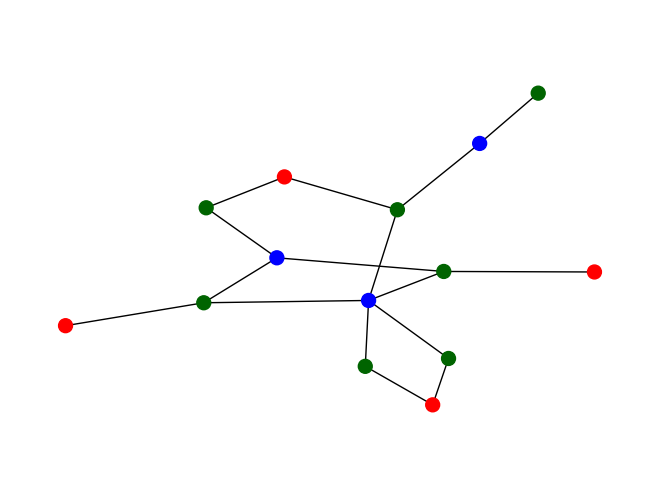

In [81]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [35]:
ind= index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['movie'].numpy()[ind]
Counter(list0)

Counter({0.0: 9, 1.0: 1})

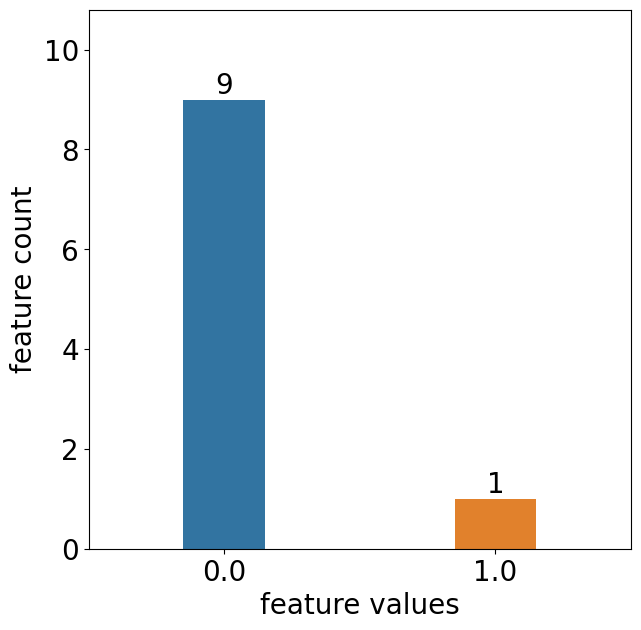

In [39]:
count_plot(list0)

Number of nodes:  3
graph id:  389
Max pred probability for class 1 is 0.7964215874671936


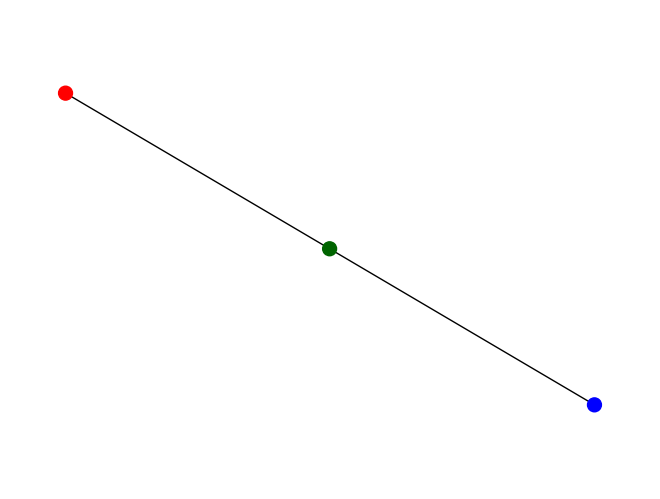

In [40]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [41]:
ind= index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['movie'].numpy()[ind]
Counter(list1)

Counter({0.0: 9, 1.0: 1})

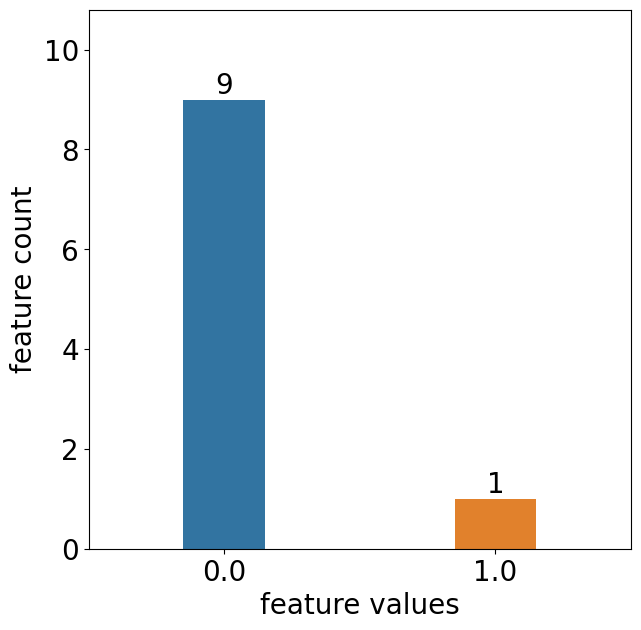

In [42]:
count_plot(list1)

Number of nodes:  11
graph id:  103
Max pred probability for class 2 is 1.0


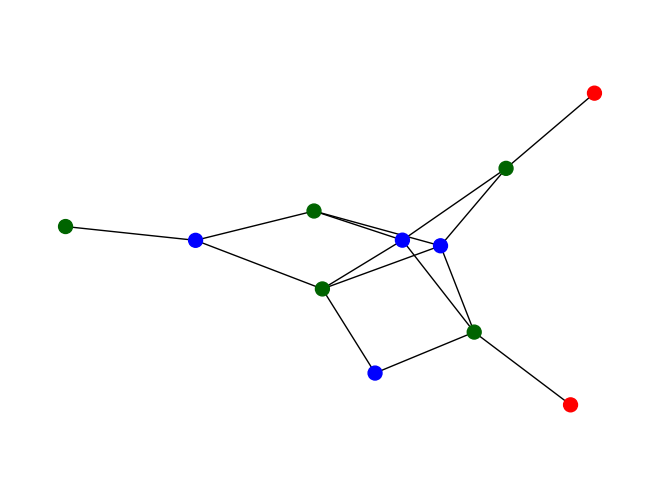

In [82]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [44]:
ind= index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['movie'].numpy()[ind]
Counter(list2)

Counter({0.0: 9, 1.0: 1})

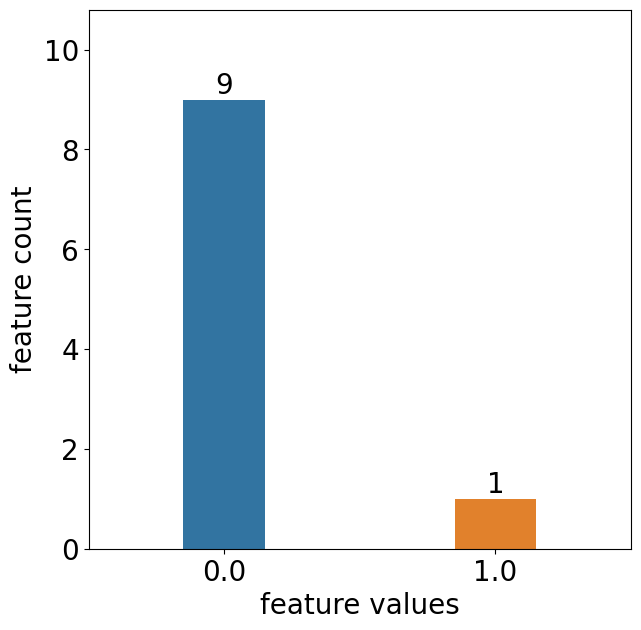

In [45]:
count_plot(list2)

In [46]:
def print_stat_cont_features(df):

    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [47]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show() 

In [48]:
#Actor
actor0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['actor'].numpy())
print_stat_cont_features(actor0_df)

mean -0.47812733
std dev 0.3659283


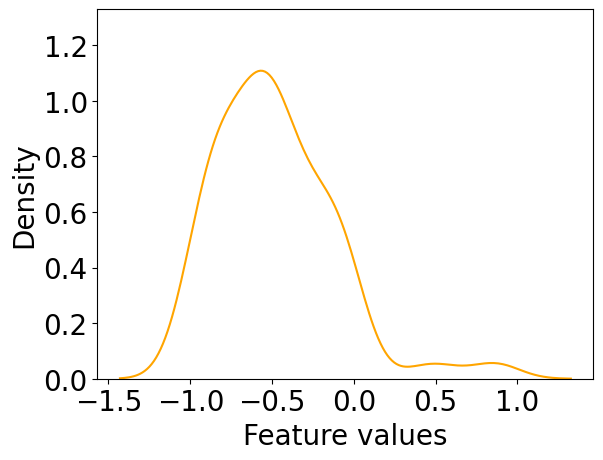

In [49]:
plot_node_feat(actor0_df)

In [50]:
actor1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['actor'].numpy())
print_stat_cont_features(actor1_df)

mean -0.41500744
std dev 0.40643394


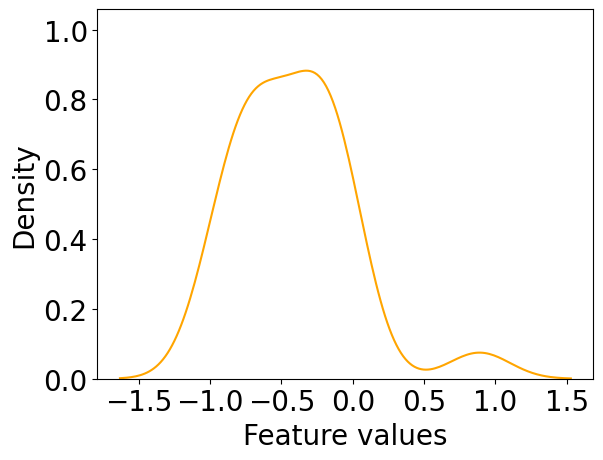

In [51]:
plot_node_feat(actor1_df)

In [52]:
actor2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['actor'].numpy())
print_stat_cont_features(actor2_df)

mean -0.44150788
std dev 0.34177786


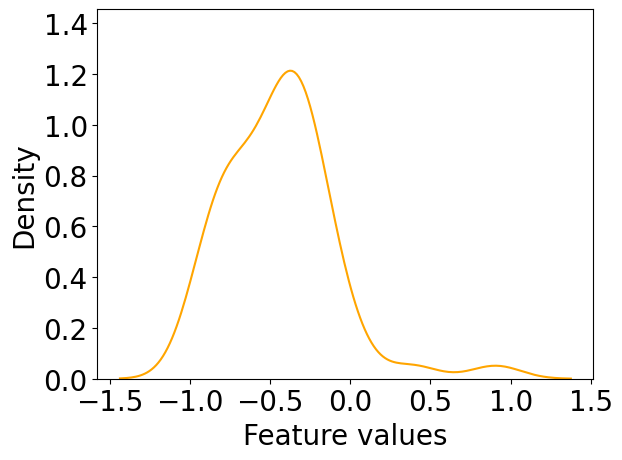

In [53]:
plot_node_feat(actor2_df)

In [54]:
#Director
director0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['director'].numpy())
print_stat_cont_features(director0_df)

mean -0.48724717
std dev 0.3159341


Text(0, 0.5, 'Density')

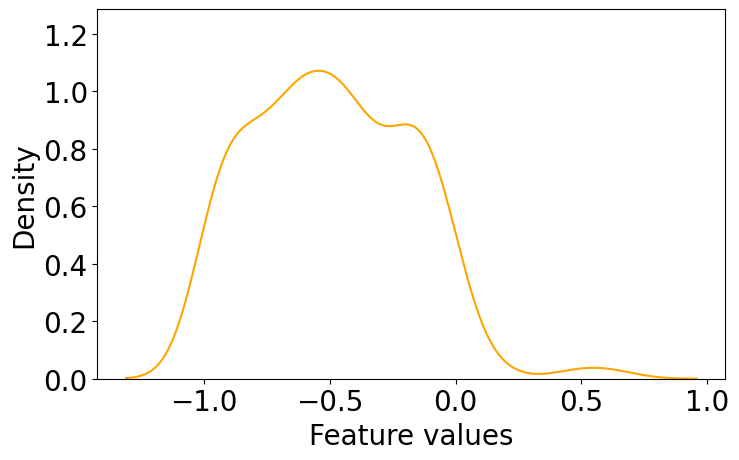

In [73]:
#plot_node_feat(director0_df)
fig, ax = plt.subplots(figsize=(8.1,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(director0_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [56]:
director1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['director'].numpy())
print_stat_cont_features(director1_df)

mean -0.50794715
std dev 0.2889649


Text(0, 0.5, 'Density')

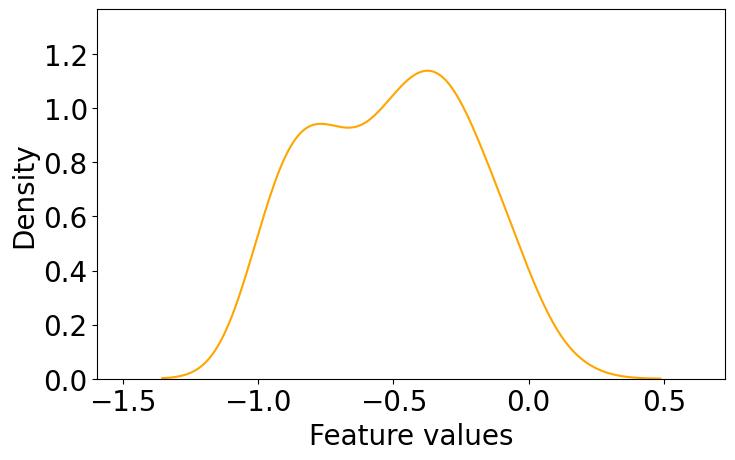

In [77]:
#plot_node_feat(director1_df)
fig, ax = plt.subplots(figsize=(8.1,4.8))
ax.set_aspect('equal', 'datalim')
sns.distplot(director1_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [58]:
director2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['director'].numpy())
print_stat_cont_features(director2_df)

mean -0.5084585
std dev 0.3167134


Text(0, 0.5, 'Density')

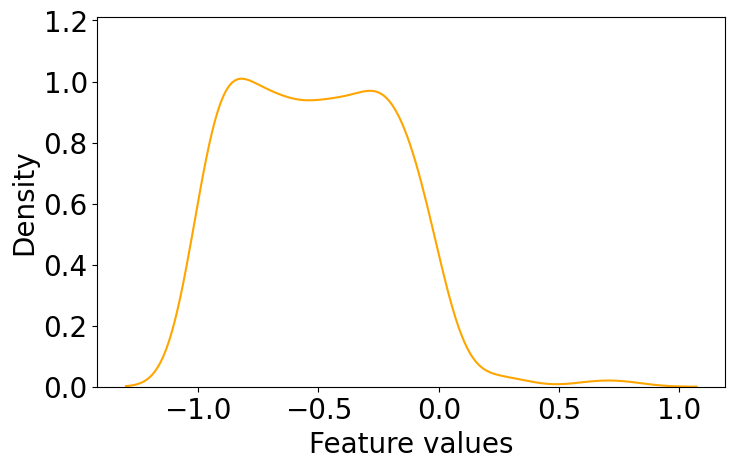

In [72]:
#plot_node_feat(director2_df)
fig, ax = plt.subplots(figsize=(8.1,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(director2_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)